# Data Madness - Den Rottsterdam
In this project we have taken the three largest cities to perform analysis on: Amsterdam, Rotterdam, The Hague. We have decided to analyse and compare the current real estate markets for each city. This analysis should help anyone interested in understanding each city's situation before investing.
We proceeded thusly: 
<ul>
<li>Scraping funda.nl for each city</li>
<li>Cleaning resulting dataset for each city</li>
<li>Perform analysis</li>
<li>Final thoughts</li>
</ul>

In [17]:
#imports for scraping
from selenium import webdriver
import time
import datetime
PATH = "/snap/bin/chromium.chromedriver"
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# # Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## Scraping
Here we develop our own scraper for funda.nl. 
This will help us get enough data on Dutch properties to perform some real estate analysis.

### Get all links from a funda.nl city search

In [21]:
#this method will scrape all house links from any city search on funda.nl
#the links will be saved as city_name_date.txt
def get_all_house_links(url, filename):

    #start driver
    driver = webdriver.Chrome(PATH)
    driver.get(url=url)
    #find last page for loop
    pages = driver.find_element_by_class_name('pagination-pages').text.split()
    last_page = int(pages[len(pages)-1]) + 1
    elems = driver.find_elements_by_xpath("//a[@href]")
    for elem in elems:
        link = elem.get_attribute("href")
        if re.search(city_name + '/huis-', link) or re.search(city_name + '/appartement-', link):
            links.add(link)
    print('Amount of house links scraped:', len(links))
    driver.delete_all_cookies()
    time.sleep(2)

    #loop for all other pages
    for page in range(2, last_page):
        page_url = url+"p"+str(page)
        print(page_url)
        source = driver.get(url=page_url)
        elems = driver.find_elements_by_xpath("//a[@href]")
        for elem in elems:
            link = elem.get_attribute("href")
            if re.search(city_name + '/huis-', link) or re.search(city_name + '/appartement-', link):
                links.add(link)
        print('Amount of house links scraped:', len(links))
        driver.delete_all_cookies()
        time.sleep(2)

    driver.close()
    
    #save as txt file
    with open(filename,'w') as f:
       f.write(str(links))  # set of numbers & a tuple

To run the method above, first select the desired url and run the two following cells:

In [22]:
#change url for desired city
url = 'https://www.funda.nl/en/koop/den-haag/'
# url = 'https://www.funda.nl/en/koop/amsterdam/'
# url = 'https://www.funda.nl/en/koop/rotterdam/'
#get city name from url
city_name = url[29:len(url)-1]
print(city_name)
#set file name
dt = datetime.datetime.now()
day = dt.strftime("%d")
month = dt.strftime("%m")
yr = dt.strftime("%y")
filename = city_name + '_' + day + '_' + month + '_' + yr + '.txt'
print(filename)

den-haag
den-haag_23_03_22.txt


In [20]:
#we only rank for 10 pages so you can see the output (in practice we did all pages available)
links = set()
get_all_house_links(url, filename)

/tmp/ipykernel_120574/3738343601.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(PATH)
/tmp/ipykernel_120574/3738343601.py:9: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  pages = driver.find_element_by_class_name('pagination-pages').text.split()
/tmp/ipykernel_120574/3738343601.py:11: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  elems = driver.find_elements_by_xpath("//a[@href]")


Amount of house links scraped: 21
https://www.funda.nl/en/koop/den-haag/p2


/tmp/ipykernel_120574/3738343601.py:25: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  elems = driver.find_elements_by_xpath("//a[@href]")


Amount of house links scraped: 38
https://www.funda.nl/en/koop/den-haag/p3
Amount of house links scraped: 56
https://www.funda.nl/en/koop/den-haag/p4
Amount of house links scraped: 74
https://www.funda.nl/en/koop/den-haag/p5
Amount of house links scraped: 93
https://www.funda.nl/en/koop/den-haag/p6
Amount of house links scraped: 110
https://www.funda.nl/en/koop/den-haag/p7
Amount of house links scraped: 126
https://www.funda.nl/en/koop/den-haag/p8
Amount of house links scraped: 143
https://www.funda.nl/en/koop/den-haag/p9
Amount of house links scraped: 161


The next cell is to prevent you from needing to scrape the house links all over again. From the text file saved in method get_all_house_links() we can create our links list and continue:

In [24]:
#get all the links from the links file
text_file = open(filename, 'r')
lines = text_file.readline()
links = lines.split(', ')

#remove the curly brackets from the set in first and last line
links[0] = links[0][1:len(links[0])]
links[len(links)-1] = links[len(links)-1][0:len(links[len(links)-1])-1]

#to remove extra apostrophes for each item in list
for link in links:
    index = links.index(link)
    temp = link[1:len(link)-1]
    links[index] = temp
    
#check we have all links
print(len(links))
print(links[0])

161
https://www.funda.nl/en/koop/den-haag/huis-42647121-vrouw-avenweg-178/?navigateSource=resultlist


### Create the dataframe of all houses from the links

Let us start by trying to access the source code of the first link using beautiful soup:

In [26]:
from bs4 import BeautifulSoup
import requests
url = links[0]
req = requests.get(url)
print(f"Request terminated with status code {req.status_code}")
print(f"Response encoded with {req.encoding}")
house_soup = BeautifulSoup(req.text, 'html.parser')
print(house_soup)

/home/roobs/environments/DA_env/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Request terminated with status code 200
Response encoded with ISO-8859-1
<!DOCTYPE html>

<html lang="nl">
<head>
<meta charset="utf-8"/>
<title>Je bent bijna op de pagina die je zoekt [funda]</title>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<script>
    (function(){
        /*! grunt-grunticon Stylesheet Loader - v2.1.6 | https://github.com/filamentgroup/grunticon | (c) 2015 Scott Jehl, Filament Group, Inc. | MIT license. */

!function(){function e(e,t){function n(){!o&&t&&(o=!0,t.call(e))}var o;e.addEventListener&&e.addEventListener("load",n),e.attachEvent&&e.attachEvent("onload",n),"isApplicationInstalled"in navigator&&"onloadcssdefined"in e&&e.onloadcssdefined(n)}!function(e){"use strict";var t=function(t,n,o){function r(e){if(d.body)return e();setTimeout(function(){r(e)})}function a(){c.addEventListener&&c.removeEventListener("load",a),c.media=o||"all"}var i,d=e.document,c=d.createElement("link");if(n)i=n;else{var s=(d.body||d.getElementsByTagName("hea

In order to scrape the data for each house listing we need to know how to access this data through selenium. Beautifulsoup does not work with funda.nl because they write their source code in an non-interpretable/encrypted way, so we proceeded with selenium as we can read the browser loaded code instead. 
To find the pertinent information for each house we needed to find the correct class name in the browser's html code. After many trials, 'object-kenmerken-body' was found.

In [30]:
driver = webdriver.Chrome(PATH)
source = driver.get(url=links[0])
#all the feature information
print("Element identified by class:", driver.find_element_by_class_name("object-kenmerken-body").text)
# time.sleep(2)
# driver.close()

/tmp/ipykernel_120574/3477160131.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(PATH)


Element identified by class: Transfer of ownership
Asking price
€ 475,000 kosten koper
Asking price per m²
€ 4,130
Listed since
March 21, 2022
Status
Available
Acceptance
Available in consultation
Construction
Kind of house
Single-family home, row house
Building type
Resale property
Year of construction
2010
Specific
Partly furnished with carpets and curtains
Type of roof
Gable roof covered with roof tiles
Surface areas and volume
Areas
Living area
115 m²
External storage space
6 m²
Plot size
126 m²
Volume in cubic meters
431 m³
Layout
Number of rooms
4 rooms (3 bedrooms)
Number of bath rooms
1 bathroom and 1 separate toilet
Bathroom facilities
Bath and toilet
Number of stories
3 stories
Facilities
Mechanical ventilation and TV via cable
Energy
Energy label
A What does this mean?
Insulation
Roof insulation, energy efficient window, insulated walls and floor insulation
Heating
CH boiler
Hot water
CH boiler
CH boiler
Intergas (gas-fired combination boiler from 2010, in ownership)
Cadastr

/tmp/ipykernel_120574/3477160131.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  print("Element identified by class:", driver.find_element_by_class_name("object-kenmerken-body").text)


We also found the house broker's name, but we do not use it later.

In [31]:
#real estate broker
print("Real estate broker:", driver.find_element_by_class_name("object-contact-aanbieder-link").text)

Real estate broker: Schieland Borsboom regio Rotterdam


/tmp/ipykernel_120574/2959353010.py:2: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  print("Real estate broker:", driver.find_element_by_class_name("object-contact-aanbieder-link").text)


Let's turn the data into a list:

In [37]:
string = driver.find_element_by_class_name("object-kenmerken-body").text
without_header = driver.find_elements_by_class_name("object-kenmerken-list")
headers = driver.find_elements_by_class_name("object-kenmerken-list-header")

data = []
for items in without_header:
    string = items.text
    string = string.split('\n')
    data.extend(string)
    
header_l = []
for items in headers:
    string = items.text
    string = string.split('\n')
    header_l.extend(string)
    
data.remove('Areas')
print(data)
print(header_l)

/tmp/ipykernel_120574/1512845398.py:1: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  string = driver.find_element_by_class_name("object-kenmerken-body").text
/tmp/ipykernel_120574/1512845398.py:2: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  without_header = driver.find_elements_by_class_name("object-kenmerken-list")
/tmp/ipykernel_120574/1512845398.py:3: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  headers = driver.find_elements_by_class_name("object-kenmerken-list-header")


['Asking price', '€ 475,000 kosten koper', 'Asking price per m²', '€ 4,130', 'Listed since', 'March 21, 2022', 'Status', 'Available', 'Acceptance', 'Available in consultation', 'Kind of house', 'Single-family home, row house', 'Building type', 'Resale property', 'Year of construction', '2010', 'Specific', 'Partly furnished with carpets and curtains', 'Type of roof', 'Gable roof covered with roof tiles', 'Living area', '115 m²', 'External storage space', '6 m²', 'Plot size', '126 m²', 'Volume in cubic meters', '431 m³', 'Number of rooms', '4 rooms (3 bedrooms)', 'Number of bath rooms', '1 bathroom and 1 separate toilet', 'Bathroom facilities', 'Bath and toilet', 'Number of stories', '3 stories', 'Facilities', 'Mechanical ventilation and TV via cable', 'Energy label', 'A What does this mean?', 'Insulation', 'Roof insulation, energy efficient window, insulated walls and floor insulation', 'Heating', 'CH boiler', 'Hot water', 'CH boiler', 'CH boiler', 'Intergas (gas-fired combination boile

We put all the data into a list and tried to separate by column name and data by taking every second item as the data and rest as column names. However we faced the issue that there were some extra words peppered in which caused our column names to flip with our data. These words were headers. The solution was to remove all headers and some other inconsistent fields.

In [38]:
index_start = data.index('Cadastral map')-1
index_end = data.index('Location')
temp_end = data[index_end:len(data)]
data = data[0:index_start]
data.extend(temp_end)
#no domain expertise on cadastral data so remove
col = data[::2]
row = data[1::2]
print(col)
print(row)

['Asking price', 'Asking price per m²', 'Listed since', 'Status', 'Acceptance', 'Kind of house', 'Building type', 'Year of construction', 'Specific', 'Type of roof', 'Living area', 'External storage space', 'Plot size', 'Volume in cubic meters', 'Number of rooms', 'Number of bath rooms', 'Bathroom facilities', 'Number of stories', 'Facilities', 'Energy label', 'Insulation', 'Heating', 'Hot water', 'CH boiler', 'Location', 'Garden', 'Back garden', 'Garden location', 'Shed / storage', 'Facilities', 'Type of parking facilities']
['€ 475,000 kosten koper', '€ 4,130', 'March 21, 2022', 'Available', 'Available in consultation', 'Single-family home, row house', 'Resale property', '2010', 'Partly furnished with carpets and curtains', 'Gable roof covered with roof tiles', '115 m²', '6 m²', '126 m²', '431 m³', '4 rooms (3 bedrooms)', '1 bathroom and 1 separate toilet', 'Bath and toilet', '3 stories', 'Mechanical ventilation and TV via cable', 'A What does this mean?', 'Roof insulation, energy ef

In [46]:
#we need to first turn it into a dictionary to make a dataframe
res = dict(zip(col, row))
print(res)

{'Asking price': '€ 475,000 kosten koper', 'Asking price per m²': '€ 4,130', 'Listed since': 'March 21, 2022', 'Status': 'Available', 'Acceptance': 'Available in consultation', 'Kind of house': 'Single-family home, row house', 'Building type': 'Resale property', 'Year of construction': '2010', 'Specific': 'Partly furnished with carpets and curtains', 'Type of roof': 'Gable roof covered with roof tiles', 'Living area': '115 m²', 'External storage space': '6 m²', 'Plot size': '126 m²', 'Volume in cubic meters': '431 m³', 'Number of rooms': '4 rooms (3 bedrooms)', 'Number of bath rooms': '1 bathroom and 1 separate toilet', 'Bathroom facilities': 'Bath and toilet', 'Number of stories': '3 stories', 'Facilities': 'Electricity', 'Energy label': 'A What does this mean?', 'Insulation': 'Roof insulation, energy efficient window, insulated walls and floor insulation', 'Heating': 'CH boiler', 'Hot water': 'CH boiler', 'CH boiler': 'Intergas (gas-fired combination boiler from 2010, in ownership)',

In [47]:
#here we append the dictionary to new dataframe to test that our columns and data are in a correct format
df = pd.DataFrame()
df = df.append(res, ignore_index=True)
df.head()

,Acceptance,Asking price,Asking price per m²,Back garden,Bathroom facilities,Building type,CH boiler,Energy label,External storage space,Facilities,...,Number of rooms,Number of stories,Plot size,Shed / storage,Specific,Status,Type of parking facilities,Type of roof,Volume in cubic meters,Year of construction
0,Available in consultation,"€ 475,000 kosten koper","€ 4,130","51 m² (9,4 meter deep and 5,4 meter broad)",Bath and toilet,Resale property,Intergas (gas-fired combination boiler from 20...,A What does this mean?,6 m²,Electricity,...,4 rooms (3 bedrooms),3 stories,126 m²,Detached wooden storage,Partly furnished with carpets and curtains,Available,Public parking,Gable roof covered with roof tiles,431 m³,2010


Once we managed to get data for a single house we need to find a way to get all the links for all houses in a city search. Then, we can iterate all the house links and create a dataframe for all:

In [48]:
#for the sake of the output we ran it 10 times using 'small' instead of 'links'
driver = webdriver.Chrome(PATH)

df = pd.DataFrame()
df.to_csv(city_name + '_real_estate.csv')

# small = links[55:65]

for link in links:
    print(link)

    source = driver.get(url=link)
    try:
        without_header = driver.find_elements_by_class_name("object-kenmerken-list")
        with_header = driver.find_element_by_class_name("object-kenmerken-body").text
        headers = driver.find_elements_by_class_name("object-kenmerken-list-header")
    except:
        without_header = []
        with_header = ''
        headers = []
    
    data = []
    for items in without_header:
        string = items.text
        string = string.split('\n')
        data.extend(string)
        
    with_header = with_header.split('\n')
    
    header_l = []
    for items in headers:
        string = items.text
        string = string.split('\n')
        header_l.extend(string)

    if 'Areas' in data:
        data.remove('Areas')
    #no domain expertise on cadastral data so remove
    if 'Cadastral map' in data:
        index_start = data.index('Cadastral map')-1
        #to find the ending index we need to find the element after 'Exterior space'
        cad_index = header_l.index('Cadastral data')
        try:
            cad_next_header = header_l[cad_index+1]
            with_header_index = with_header.index(cad_next_header)
            index_end = data.index(with_header[with_header_index+1])
            temp_end = data[index_end:len(data)]
            data = data[0:index_start]
            data.extend(temp_end)
        except:
            data = data[0:index_start-1]
    col = data[::2]
    row = data[1::2]
    col.append('url')
    row.append(link)
    res = dict(zip(col, row))
    df = df.append(res, ignore_index=True)
    driver.delete_all_cookies()
    os.remove(city_name + '_real_estate.csv')
    time.sleep(2)
    df.to_csv(city_name + '_real_estate.csv')

df.head()

/tmp/ipykernel_120574/880620361.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(PATH)


https://www.funda.nl/en/koop/den-haag/huis-42649372-buenos-aireshof-44/?navigateSource=resultlist


/tmp/ipykernel_120574/880620361.py:13: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  without_header = driver.find_elements_by_class_name("object-kenmerken-list")
/tmp/ipykernel_120574/880620361.py:14: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  with_header = driver.find_element_by_class_name("object-kenmerken-body").text
/tmp/ipykernel_120574/880620361.py:15: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  headers = driver.find_elements_by_class_name("object-kenmerken-list-header")


https://www.funda.nl/en/koop/den-haag/appartement-42608756-fahrenheitstraat-80/?navigateSource=resultlist
https://www.funda.nl/en/koop/den-haag/huis-49635699-de-rhijenhof-6-b/?navigateSource=resultlist
https://www.funda.nl/en/koop/den-haag/appartement-88096785-arabislaan-70/?navigateSource=toppositie
https://www.funda.nl/en/koop/den-haag/huis-42629060-singravenstraat-18/?navigateSource=resultlist
https://www.funda.nl/en/koop/den-haag/appartement-42620001-ranonkelstraat-335/?navigateSource=resultlist
https://www.funda.nl/en/koop/den-haag/appartement-42640445-schipborgstraat-73/?navigateSource=resultlist
https://www.funda.nl/en/koop/den-haag/appartement-42646170-anna-paulownastraat-8/?navigateSource=resultlist
https://www.funda.nl/en/koop/den-haag/huis-88001749-menninckstraat-92/?navigateSource=resultlist
https://www.funda.nl/en/koop/den-haag/huis-42637954-laan-van-wateringse-veld-1590/?navigateSource=resultlist


,Acceptance,Asking price,Asking price per m²,Balcony/roof garden,Bathroom facilities,Building type,Energy label,Exterior space attached to the building,Facilities,Heating,...,Periodic contribution,Registration with KvK,Reserve fund present,Type apartment,VVE (Owners Association) contribution,Capacity,Other space inside the building,Type of garage,External storage space,Quality marks
0,Available in consultation,"€ 425,000 kosten koper","€ 3,295","Roof terrace present, balcony present and fren...","Bath, shower and toilet",Resale property,A What does this mean?,15 m²,"Electricity, heating and running water",District heating,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Available in consultation,"€ 315,000 kosten koper","€ 3,938",NaN,Bath and toilet,Resale property,C What does this mean?,4 m²,NaN,CH boiler,...,No,Yes,No,Ground-floor apartment (apartment),€ 20.00 per month,NaN,NaN,NaN,NaN,NaN
2,Available in consultation,"€ 1,700,000 kosten koper","€ 3,505",Roof terrace present,"Sauna, steam cabin, bath, 2 showers and toilet",Resale property,A 0.50 What does this mean?,45 m²,"Electrical door, electricity, heating and runn...","CH boiler, fireplace and complete floor heating",...,NaN,NaN,NaN,NaN,NaN,2 cars,95 m²,Attached brick garage and parking place,NaN,NaN
3,Available immediately,"€ 389,500 kosten koper","€ 4,376",Balcony present,Shower,Resale property,E What does this mean?,14 m²,"Optical fibre, mechanical ventilation and TV v...",CH boiler,...,Yes (€ 121.75 per month),Yes,Yes,Mezzanine (apartment),€ 121.75 per month,NaN,16 m²,NaN,4 m²,Energie Prestatie Advies
4,Available in consultation,"€ 475,000 kosten koper","€ 3,992",NaN,Bath,Resale property,B What does this mean?,NaN,Electricity,CH boiler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parking place,6 m²,NaN


### Cleaning

Here we would like to simplify the dataframe so that we can perform seamless analysis.
First we load all three datasets and concatenate them into a single super-dataset:

In [51]:
amst_df = pd.read_csv("amsterdam_real_estate_final.csv")
haag_df = pd.read_csv("denHaag_real_estate.csv")
rott_df = pd.read_csv("rotterdam_real_estate.csv")

#To preserve the city in which each house is, we add a new column with the city name 
amst_df['city'] = 'amst'
haag_df['city'] = 'haag'
rott_df['city'] = 'rott'

df = pd.concat([amst_df, haag_df, rott_df], ignore_index=True)

/home/roobs/environments/DA_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (53,55,57,58,59,64,66,69,72,78,86,87,89,90,92,93,95,96,97,99,102,103,104,106,109,112,114,117,118,119,120,132,134,135,138,139,140,145,146,152,153,154,155,157,158,160,162,163,164,165,166,168,169,170,172,176,178,179,180,181,182,188,189,190,193,195,198,199,200,201,202,203,204,205,206,208,209,210,214,215,216,217,218,219,220,221,222,223,224,229,232,233,235,236,237,238,239,240,242,243,244,246,247,249,251,252,254,255,256,258,262,263,264,267,268,269,270,273,275,277,281,282,283,284,285,286,288,289,290,291,292,294,295,296,297,298,299,300,301,302,303,305,308,309,310,311,312,313,315,317,318,320,321,322,323,328,329,331,334,339,342,344,345,346,348,351,354,358,359,360,361,362,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,41

In [52]:
# sanity check
df.shape

(4993, 1537)

To begin cleaning, all the unnamed columns are removed as we cannot verify the meaning of their contents:

In [53]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

We check the total number of NaN values per column:

In [56]:
total = df.isna().sum()
pd.set_option('display.max_rows', total.shape[0]+1)
print(total[0:10])

Acceptance                                  395
Asking price                                233
Asking price per m²                         278
Bathroom facilities                        1774
Building type                               352
Energy label                               1252
Exterior space attached to the building    1935
Facilities                                 1591
Garden                                     3204
Heating                                     718
dtype: int64


A lot of columns are created for very few houses as they have inconsistent variable names and adapting our scraping to each individual case would be a mountain-load of work. As a remedy, we remove the columns, then rows, (in the 2 following cells) containing more than a certain amount of NaN values. The column threshold 200 was chosen to keep around 50 attributes for further analysis, and the row threshold of 25 is used to certify that all our rows have more than half of the attributes present.

In [57]:
#drop when more than X nan value in the colum
df1 = df.dropna(axis=1,thresh=200)
#1200 => 16 columns
#1600 => 46 columns (Harry: same as rotterdam but here 49 columns)
df1.head()

,Acceptance,Asking price,Asking price per m²,Bathroom facilities,Building type,Energy label,Exterior space attached to the building,Facilities,Garden,Heating,...,Quality marks,Service charges,Sun terrace,Type of garage,Other space inside the building,Garden location,Capacity,Back garden,Construction period,city
0,Available in consultation,"€ 1,740,000 kosten koper","€ 6,374","Bath, 2 showers and 2 toilets",Resale property,F What does this mean?,10 m²,Passive ventilation system and TV via cable,Patio/atrium,Gas heaters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
1,Available in consultation,"€ 550,000 kosten koper","€ 5,140",Bath and shower,Resale property,NaN,12 m²,Elevator and mechanical ventilation,NaN,CH boiler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
2,Available in consultation,"€ 800,000 kosten koper","€ 6,504",NaN,Resale property,F What does this mean?,4 m²,NaN,NaN,CH boiler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
4,NaN,"€ 545,000 vrij op naam","€ 6,124",Shower,New property,A+++ What does this mean?,22 m²,NaN,Sun terrace,District heating,...,Woningborg garantiecertificaat,€ 133 per month,"19 m² (2,6 meter deep and 7,2 meter broad)",Underground parking,NaN,NaN,NaN,NaN,NaN,amst


In [58]:
df2 = df1.dropna(thresh=25)
df2.head()

,Acceptance,Asking price,Asking price per m²,Bathroom facilities,Building type,Energy label,Exterior space attached to the building,Facilities,Garden,Heating,...,Quality marks,Service charges,Sun terrace,Type of garage,Other space inside the building,Garden location,Capacity,Back garden,Construction period,city
0,Available in consultation,"€ 1,740,000 kosten koper","€ 6,374","Bath, 2 showers and 2 toilets",Resale property,F What does this mean?,10 m²,Passive ventilation system and TV via cable,Patio/atrium,Gas heaters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
1,Available in consultation,"€ 550,000 kosten koper","€ 5,140",Bath and shower,Resale property,NaN,12 m²,Elevator and mechanical ventilation,NaN,CH boiler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
2,Available in consultation,"€ 800,000 kosten koper","€ 6,504",NaN,Resale property,F What does this mean?,4 m²,NaN,NaN,CH boiler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
4,NaN,"€ 545,000 vrij op naam","€ 6,124",Shower,New property,A+++ What does this mean?,22 m²,NaN,Sun terrace,District heating,...,Woningborg garantiecertificaat,€ 133 per month,"19 m² (2,6 meter deep and 7,2 meter broad)",Underground parking,NaN,NaN,NaN,NaN,NaN,amst
5,Available in consultation,"€ 4,350,000 vrij op naam","€ 11,417",NaN,New property,NaN,110 m²,NaN,Sun terrace,Complete floor heating,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst


Sanity check to see that we do not remove too many house listings for a specific city.

In [60]:
print(df.shape, df1.shape, df2.shape)
print(df1.groupby(['city']).size())
print(df2.groupby(['city']).size())

(4993, 1530) (4993, 52) (4209, 52)
city
amst    2018
haag    1290
rott    1685
dtype: int64
city
amst    1838
haag    1202
rott    1169
dtype: int64


The following is the madness of isolating numbers from string values present in columns where the number is important for analysis. i.e. '2 bathrooms' becomes '2' in a column named 'bathroom'. 

In [61]:

cols_to_check = ['Energy label','Listed since','External storage space','Located at',
                 'VVE (Owners Association) contribution','Volume in cubic meters',
                 'Provisional energy label','Year of construction','Service charges',
                 'Other space inside the building']



df2[cols_to_check] = df2[cols_to_check].replace({'€':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'kosten koper':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'vrij op naam':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'m²':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'What does this mean?':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'months':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'floor':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'th':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'nd':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'rd':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'st':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'floor':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'weeks':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'Today':'0'}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'weeks':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'per':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'month':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'mon':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'Not available':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'After ':''}, regex=True)
df2[cols_to_check] = df2[cols_to_check].replace({'Before ':''}, regex=True)




df2['Asking price'] = df2['Asking price'].str.replace(r'\D', '')
df2['Exterior space attached to the building'] = df2['Exterior space attached to the building'].str.replace(r'\D', '')
df2['Number of stories'] = df2['Number of stories'].str.replace(r'\D', '')
df2['Asking price per m²'] = df2['Asking price per m²'].str.replace(r'\D', '')
df2['Living area'] = df2['Living area'].str.replace(r'\D', '')
df2['Plot size'] = df2['Plot size'].str.replace(r'\D', '')
df2['External storage space'] = df2['External storage space'].str.replace(r'\D', '')
df2['Volume in cubic meters'] = df2['Volume in cubic meters'].str.replace(r'\D', '')



df2['Building type'] = df2['Building type'].replace({' property':''}, regex=True)


df2['Number of rooms'] = df2['Number of rooms'].replace({r"\(":","}, regex=True)
df2['Number of rooms'] = df2['Number of rooms'].replace({r"\)":""}, regex=True)
df2['Number of rooms'] = df2['Number of rooms'].replace({'rooms':''}, regex=True)
df2['Number of rooms'] = df2['Number of rooms'].replace({'bedrooms':''}, regex=True)
df2['Number of rooms'] = df2['Number of rooms'].replace({'bedroom':''}, regex=True)
df2['Number of rooms'] = df2['Number of rooms'].replace({'bed':''}, regex=True)
df2['Number of rooms'] = df2['Number of rooms'].replace({'room':''}, regex=True)

df2['Number of bath rooms'] = df2['Number of bath rooms'].replace({'bathrooms':''}, regex=True)
df2['Number of bath rooms'] = df2['Number of bath rooms'].replace({'bathroom':''}, regex=True)
df2['Number of bath rooms'] = df2['Number of bath rooms'].replace({'and':','}, regex=True)
df2['Number of bath rooms'] = df2['Number of bath rooms'].replace({'separate toilets':''}, regex=True)
df2['Number of bath rooms'] = df2['Number of bath rooms'].replace({'separate toilet':''}, regex=True)


df2['Energy label'] = df2['Energy label'].replace({'Not required':''}, regex=True)
df2['Provisional energy label'] = df2['Provisional energy label'].replace({r"\?":""}, regex=True) 
df2['Energy label'] = df2['Energy label'].replace({r"\?":" "}, regex=True)



df2['Listed since'] = df2['Listed since'].replace({'March 1, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 2, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 3, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 4, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 5, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 6, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 7, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 8, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 9, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 10, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 11, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 12, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 13, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 14, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 15, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 16, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 17, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 18, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 19, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 20, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 21, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 22, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 23, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 24, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 25, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 26, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 27, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 28, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 29, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'March 30, 2022':'0'}, regex=True)
df2['Listed since'] = df2['Listed since'].replace({'February 28, 2022':'0'}, regex=True)

df2['Energy label'] = df2['Energy label'].replace({r"\.":""}, regex=True)
df2['Energy label'] = df2['Energy label'].str.replace('\d+', '')

#df2['Back garden'] = df2['Back garden'].replace(r"\(.*\)",'')


df2.head()

/home/roobs/environments/DA_env/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/tmp/ipykernel_120574/2484878139.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Asking price'] = df2['Asking price'].str.replace(r'\D', '')
/tmp/ipykernel_120574/2484878139.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,Acceptance,Asking price,Asking price per m²,Bathroom facilities,Building type,Energy label,Exterior space attached to the building,Facilities,Garden,Heating,...,Quality marks,Service charges,Sun terrace,Type of garage,Other space inside the building,Garden location,Capacity,Back garden,Construction period,city
0,Available in consultation,1740000,6374,"Bath, 2 showers and 2 toilets",Resale,F,10,Passive ventilation system and TV via cable,Patio/atrium,Gas heaters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
1,Available in consultation,550000,5140,Bath and shower,Resale,NaN,12,Elevator and mechanical ventilation,NaN,CH boiler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
2,Available in consultation,800000,6504,NaN,Resale,F,4,NaN,NaN,CH boiler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst
4,NaN,545000,6124,Shower,New,A+++,22,NaN,Sun terrace,District heating,...,Woningborg garantiecertificaat,133,"19 m² (2,6 meter deep and 7,2 meter broad)",Underground parking,NaN,NaN,NaN,NaN,NaN,amst
5,Available in consultation,4350000,11417,NaN,New,NaN,110,NaN,Sun terrace,Complete floor heating,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amst


More of the previous...

In [62]:
df2.rename(columns={'Number of rooms': 'rooms'}, inplace=True)
df2.rooms.str.split(expand=True,)
df2[['rooms','bedroom']] = df2.rooms.str.split(",",expand=True)

df2.rename(columns={'Number of bath rooms': 'bathrooms'}, inplace=True)
df2.bathrooms.str.split(expand=True,)
df2[['bathrooms','toilet']] = df2.bathrooms.str.split(",",expand=True)

/home/roobs/environments/DA_env/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/roobs/environments/DA_env/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [63]:
df2.rename(columns={'Periodic contribution': 'Periodic_contribution'}, inplace=True)
df2.Periodic_contribution.str.split(expand=True,)
df2[['Periodic_contribution','price_contribution']] = df2.Periodic_contribution.str.split(r"\(",expand=True)
df2['price_contribution'] = df2['price_contribution'].replace({'€':''}, regex=True)
df2['price_contribution'] = df2['price_contribution'].replace({'per month':''}, regex=True)
df2['price_contribution'] = df2['price_contribution'].replace({r"\)":''}, regex=True)

/tmp/ipykernel_120574/3512966849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_contribution'] = df2['price_contribution'].replace({'€':''}, regex=True)
/tmp/ipykernel_120574/3512966849.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_contribution'] = df2['price_contribution'].replace({'per month':''}, regex=True)
/tmp/ipykernel_120574/3512966849.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [64]:
df2.rename(columns={'Back garden': 'Back_garden'}, inplace=True)
df2.Back_garden.str.split(expand=True,)
df2[['Back_garden','Back_garden_measure']] = df2.Back_garden.str.split(r"\(",expand=True)
del df2["Back_garden_measure"]
df2['Back_garden'] = df2['Back_garden'].replace({'m²':''}, regex=True)

/tmp/ipykernel_120574/3189604098.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Back_garden'] = df2['Back_garden'].replace({'m²':''}, regex=True)


In [65]:
df2['Building type'] = df2['Building type'].replace({'property':''}, regex=True)
df2['Year of construction'] = df2['Year of construction'].replace({'After':''}, regex=True)
df2['Year of construction'] = df2['Year of construction'].replace({'Before':''}, regex=True)
df2['Balcony/roof garden'] = df2['Balcony/roof garden'].replace({'present':''}, regex=True)
df2['Garden location'] = df2['Garden location'].replace({'Located at the':''}, regex=True)
df2['Garden location'] = df2['Garden location'].replace({'accessible via the rear':''}, regex=True)
df2['Type of roof'] = df2['Type of roof'].replace({'roof':''}, regex=True)
df2['Type of roof'] = df2['Type of roof'].replace({'roofing':''}, regex=True)

/tmp/ipykernel_120574/2081680597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Building type'] = df2['Building type'].replace({'property':''}, regex=True)
/tmp/ipykernel_120574/2081680597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Year of construction'] = df2['Year of construction'].replace({'After':''}, regex=True)
/tmp/ipykernel_120574/2081680597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Since the variable 'Asking price' is paramount to further our analysis, we drop any rows not containing an asking price. 

In [66]:
df3 = df2.dropna(subset=['Asking price'])


In [69]:
# Interim save.
df3.to_csv('funda.csv')

In [90]:
df = pd.read_csv("funda.csv")

In [91]:
df.shape

(4206, 56)

Some attributes we wanted to base analysis on was the presence of outside space whether terrace, patio or garden. Therefore, we added columns which found the respective garden/terrace/patio string as boolean values.

In [92]:
# df['Asking price'] = df['Asking price'].astype(float)
print(df.iloc[3]['url'])
df['Terrace'] = (df['Garden'].str.contains('trium')) | (df['Garden'].str.contains('atio')) | (df['Garden'].str.contains('errace'))
df['Garden1'] = (df['Garden'].str.contains('arden')) | (df['Garden'].str.contains('arden'))
# df['Garden'] = df['Garden'].fillna('False',inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

https://www.funda.nl/en/koop/amsterdam/appartement-42557195-van-suchtelen-van-de-haarestraat-121


,Acceptance,Asking price,Asking price per m²,Bathroom facilities,Building type,Energy label,Exterior space attached to the building,Facilities,Garden,Heating,...,Garden location,Capacity,Back_garden,Construction period,city,bedroom,toilet,price_contribution,Terrace,Garden1
0,Available in consultation,1740000.0,6374.0,"Bath, 2 showers and 2 toilets",Resale,F,10.0,Passive ventilation system and TV via cable,Patio/atrium,Gas heaters,...,NaN,NaN,NaN,NaN,amst,4.0,NaN,NaN,True,False
1,Available in consultation,550000.0,5140.0,Bath and shower,Resale,NaN,12.0,Elevator and mechanical ventilation,NaN,CH boiler,...,NaN,NaN,NaN,NaN,amst,3.0,2.0,NaN,False,False
2,Available in consultation,800000.0,6504.0,NaN,Resale,F,4.0,NaN,NaN,CH boiler,...,NaN,NaN,NaN,NaN,amst,4.0,NaN,232.00,False,False
3,NaN,545000.0,6124.0,Shower,New,A+++,22.0,NaN,Sun terrace,District heating,...,NaN,NaN,NaN,NaN,amst,3.0,1.0,NaN,True,False
4,Available in consultation,4350000.0,11417.0,NaN,New,NaN,110.0,NaN,Sun terrace,Complete floor heating,...,NaN,NaN,NaN,NaN,amst,5.0,NaN,NaN,True,False


To kickstart our analysis, we recycle some graphs from the 2nd clinic. We begin by quick descriptions for the total dataset.

In [93]:
df.describe()

,Asking price,Asking price per m²,Exterior space attached to the building,Living area,bathrooms,rooms,Number of stories,Plot size,Volume in cubic meters,Year of construction,External storage space,Other space inside the building,bedroom,toilet
count,4.164000e+03,4165.000000,2955.000000,4206.000000,3843.000000,4206.000000,4206.000000,718.000000,4206.000000,3995.000000,2257.000000,733.000000,4172.000000,2814.000000
mean,6.137611e+05,5544.385834,13.770897,108.524251,1.184751,3.967665,1.847361,211.320334,363.850214,1957.526658,7.957909,12.260573,2.667785,1.158493
std,5.953530e+05,2319.925177,16.786221,62.972185,0.479357,1.668880,1.682250,1408.910420,230.996728,53.447314,8.960685,19.435378,1.284654,0.425507
min,1.395000e+05,2102.000000,1.000000,15.000000,1.000000,1.000000,1.000000,19.000000,51.000000,1187.000000,1.000000,1.000000,1.000000,1.000000
25%,3.300000e+05,3820.000000,5.000000,71.000000,1.000000,3.000000,1.000000,107.000000,230.000000,1927.000000,4.000000,1.000000,2.000000,1.000000
50%,4.500000e+05,4878.000000,8.000000,95.000000,1.000000,4.000000,1.000000,136.000000,310.000000,1961.000000,6.000000,5.000000,2.000000,1.000000
75%,6.500000e+05,7065.000000,15.000000,128.000000,1.000000,5.000000,2.000000,177.000000,427.750000,2001.000000,8.000000,14.000000,3.000000,1.000000
max,1.050000e+07,34426.000000,224.000000,834.000000,6.000000,24.000000,43.000000,37800.000000,2923.000000,2024.000000,306.000000,177.000000,12.000000,5.000000


There is a leap in magnitude between the 3rd quartile and the maximum value. To further investigate we craft some multiplots that include a histogram, a scatter plot and a box plot of the asking prices for each of the three cities - courtesy of the second clinic.

/home/roobs/environments/DA_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/roobs/environments/DA_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/roobs/environments/DA_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result

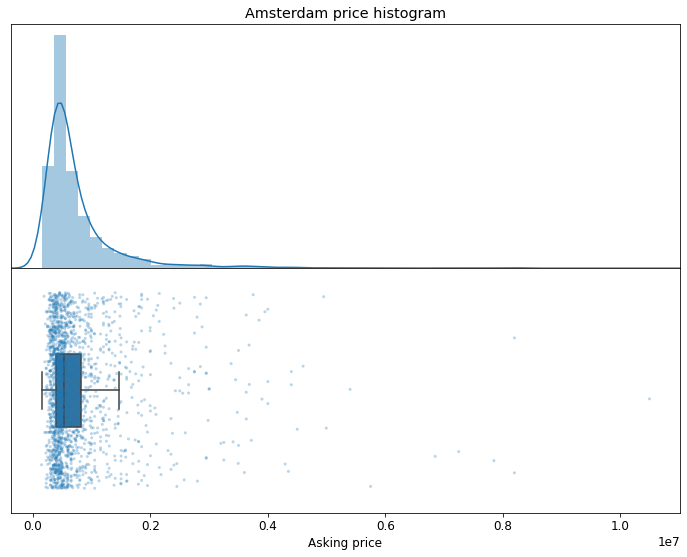

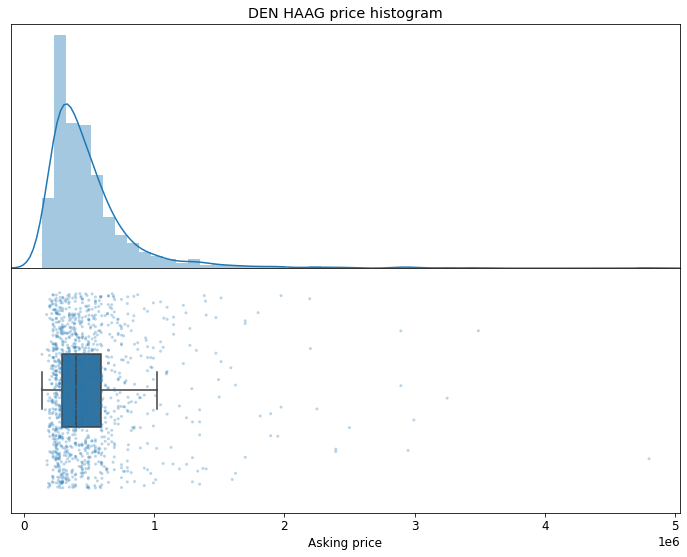

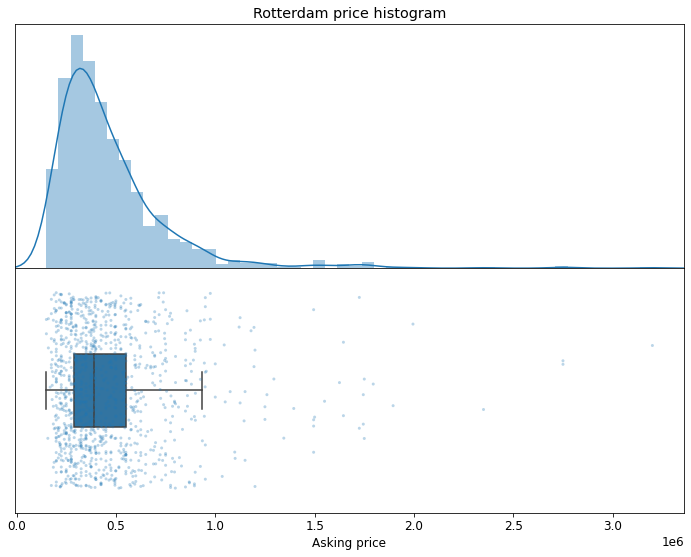

In [94]:
fig, axs = plt.subplots(nrows=2)
plt.title('Amsterdam price histogram', pad=250)
sns.distplot(
    df.loc[df['city']=='amst']['Asking price'], 
    ax=axs[0]
)
sns.stripplot(
    df.loc[df['city']=='amst']['Asking price'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df.loc[df['city']=='amst']['Asking price'], 
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df.loc[df['city']=='amst']['Asking price']) * 0.05
xmin = np.min(df.loc[df['city']=='amst']['Asking price']) - spacer
xmax = np.max(df.loc[df['city']=='amst']['Asking price']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
# axs[1].artists[0].set_facecolor('white')

fig, axs = plt.subplots(nrows=2)
plt.title('DEN HAAG price histogram', pad=250)

sns.distplot(
    df.loc[df['city']=='haag']['Asking price'], 
    ax=axs[0]
)
sns.stripplot(
    df.loc[df['city']=='haag']['Asking price'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df.loc[df['city']=='haag']['Asking price'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df.loc[df['city']=='haag']['Asking price']) * 0.05
xmin = np.min(df.loc[df['city']=='haag']['Asking price']) - spacer
xmax = np.max(df.loc[df['city']=='haag']['Asking price']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
# axs[1].artists[0].set_facecolor('white')

fig, axs = plt.subplots(nrows=2)
plt.title('Rotterdam price histogram', pad=250)

sns.distplot(
    df.loc[df['city']=='rott']['Asking price'], 
    ax=axs[0]
)
sns.stripplot(
    df.loc[df['city']=='rott']['Asking price'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df.loc[df['city']=='rott']['Asking price'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df.loc[df['city']=='rott']['Asking price']) * 0.05
xmin = np.min(df.loc[df['city']=='rott']['Asking price']) - spacer
xmax = np.max(df.loc[df['city']=='rott']['Asking price']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
# axs[1].artists[0].set_facecolor('white')

The culprit is now clearly visible as a listing in Amsterdam. We checked the link and saw that it was a newly built massive penthouse in Amsterdam and deemed it to be unreasonably expensive before slicing it off. If you are interested in possibly purchasing the property we have helpfully included the link below.

In [104]:
# remove outliers for asking price > 9mill
print(df.loc[df['Asking price'] > 9000000]['url'].iloc[0])
df = df.loc[df['Asking price'] <= 9000000]

https://www.funda.nl/en/koop/amsterdam/appartement-42583348-dam-5-y


<AxesSubplot:xlabel='city', ylabel='Asking price'>

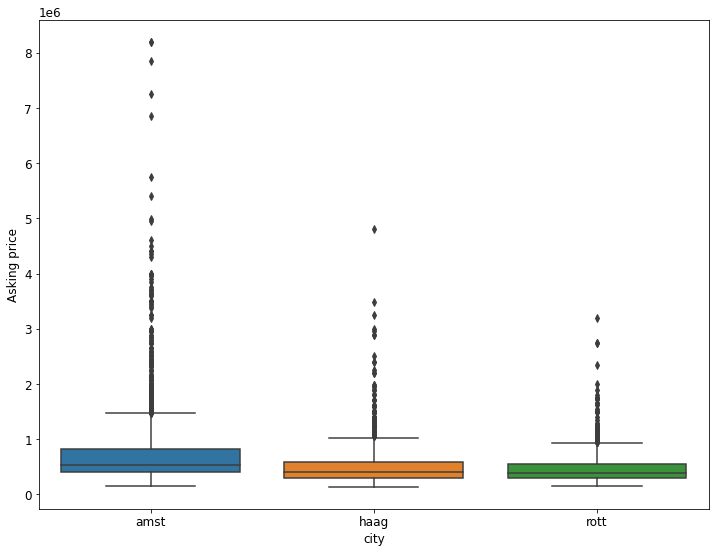

In [105]:
sns.boxplot(
    x='city',
    y='Asking price',
    data=df.sort_values('city')
)

This plot seems to point to a relatively larger amount of houses above the 1 million price range in Amsterdam, to confirm this we visualize the total number of houses above 1 million euros for each city:

In [167]:
#calculate percentages of houses above 1mill for each city
df1 = df.loc[(df['Asking price'] > 1000000)]
df2 = df1['city'].value_counts().to_frame().transpose()
df3 = df['city'].value_counts().to_frame().transpose()
df4 = (df2/df3)*100
df4.head()

,amst,haag,rott
city,17.239498,6.505421,3.97878


Text(0, 0.5, 'Percentage of houses above 1 million euros')

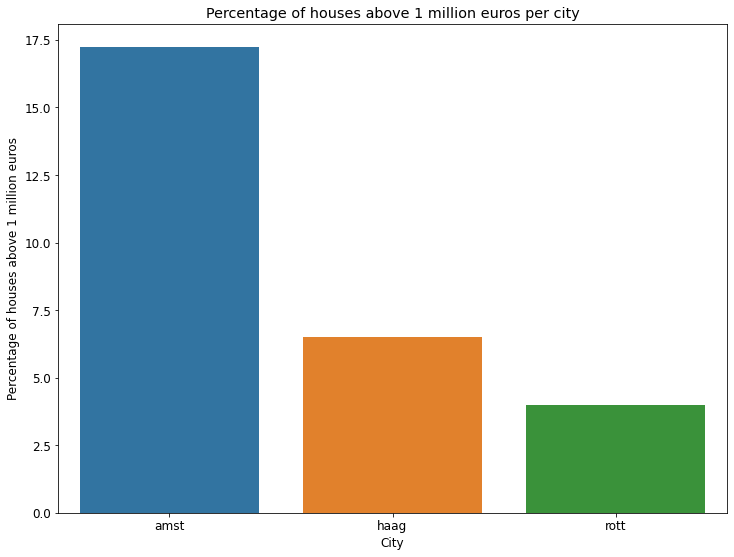

In [168]:
sns.barplot(data=df4)
plt.title('Percentage of houses above 1 million euros per city')
plt.xlabel('City')
plt.ylabel('Percentage of houses above 1 million euros')

This barchart clearly shows that Amsterdam has a much higher proportion of expensive houses in comparison to The Hague and Rotterdam (even more than double).

https://www.funda.nl/en/koop/amsterdam/huis-42615393-hemonystraat-49


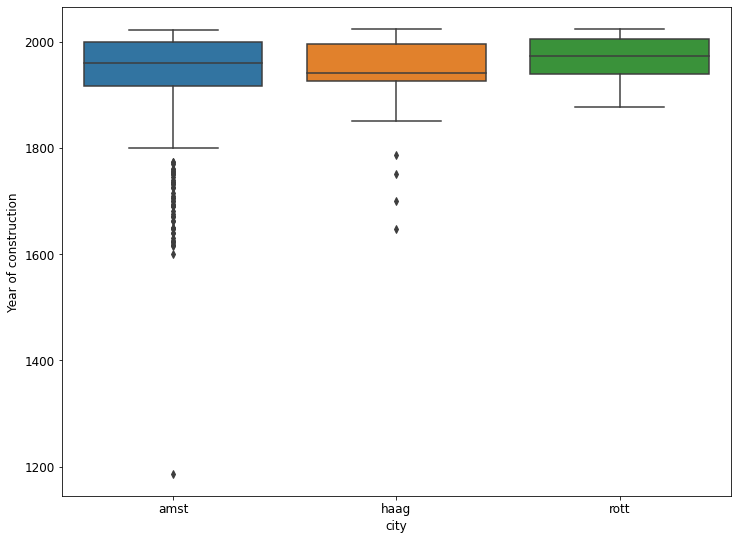

In [166]:
sns.boxplot(
    x='city',
    y='Year of construction',
    data=df.sort_values('city')
)

# can indicate rotterdam has more construction/renovations
print(df.loc[df['Year of construction'] < 1400]['url'].iloc[0])

Here we notice that Amsterdam has many old houses (older than 1800), these houses could be selling for more than the average house price. We want to figure out if the reason of Amsterdam's high percentage of houses above 1 million is because it has more houses built later than 1800. So we calculate the average year of construction of houses above 1 million euros.

In [181]:
df1.shape
print('Average year of construction for Amsterdam:', df1.loc[df1['city'] == 'amst']['Year of construction'].mean())
print('Average year of construction for The Hague:', df1.loc[df1['city'] == 'haag']['Year of construction'].mean())
print('Average year of construction for Rotterdam:', df1.loc[df1['city'] == 'rott']['Year of construction'].mean())

Average year of construction for Amsterdam: 1921.5639344262295
Average year of construction for The Hague: 1959.5142857142857
Average year of construction for Rotterdam: 1990.6


Our theory is not completely dismantled here as the average house ages follow a similar trend as the percentage of houses above one million. 

Next we would like to explore if the Asking price is correlated with any other variables. We start by plotting Asking price vs living area.

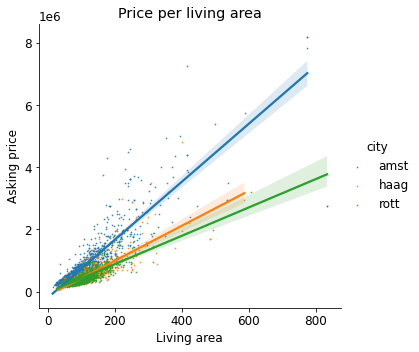

In [182]:
lmplot = sns.lmplot(data=df, x='Living area', y='Asking price', hue='city', fit_reg=True, scatter_kws={"s": 0.5})
lmplot.set(title='Price per living area')

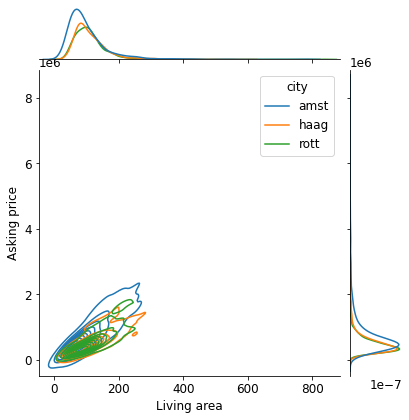

In [192]:
sns.jointplot(
    data=df,
    x="Living area", y="Asking price", hue="city",
    kind="kde"
)

Resale    3876
New        287
Name: Building type, dtype: int64


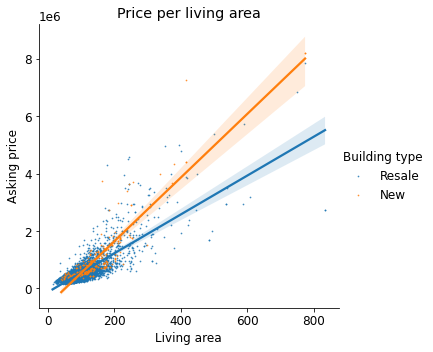

In [188]:
lmplot = sns.lmplot(data=df, x='Living area', y='Asking price', hue='Building type', fit_reg=True, scatter_kws={"s": 0.5})
lmplot.set(title='Price per living area')
print(df['Building type'].value_counts())

Despite this graph looking like some valuable information may be gleaned from it, when looking at the count of resale vs new houses there is such a large discrepancy that drawing conclusions from it could lead to incorrect results.

So we take a look at relation between asking price and the existence of a terrace.

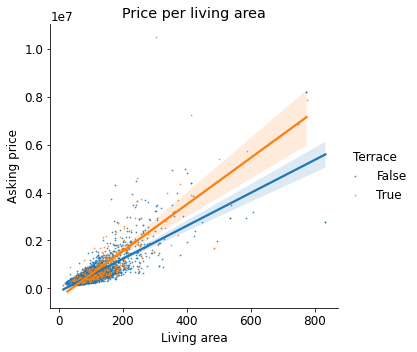

In [270]:
lmplot = sns.lmplot(data=df, x='Living area', y='Asking price', hue='Terrace', fit_reg=True, scatter_kws={"s": 0.5})
lmplot.set(title='Price per living area')

In [284]:
df1 = df.groupby('bedroom')['Asking price'].agg('mean')
# sns.barplot(data=df1, x=range(0,11), y='bedroom')
# plt.title('Age and Class of Titanic Passengers')
# plt.xlabel('Class')
# plt.ylabel('Mean Age')
df1.head()

bedroom
1.0    374416.286154
2.0    485549.077957
3.0    661765.173479
4.0    805687.753022
5.0    934922.885572
Name: Asking price, dtype: float64